In [1]:
meta_path = "D:/models/uno/best_model.pt"


hmibr_path = "D:/data/download/12673/hmi/hmi.sharp_cea_720s.7115.20170905_000000_TAI.Br.fits"
aia171_path =  "D:/data/download/12673/aia/171/aia_lev1_171a_2017_09_05t00_00_09_34z_image_lev1.fits"
aia94_path = "D:/data/download/12673/aia/94/aia_lev1_94a_2017_09_05t00_00_11_11z_image_lev1.fits"

isee_path = "F:/isee_dataset/12673/label/label_12673_20170905_000000.npz"
isee_input = "F:/isee_dataset/12673/input/input_12673_20170905_000000.npz"

isee_nf2_fp = "D:/data/extrapolation/nf2/7115_20170905_000000_TAI/nf2.npz"
isee_preprowie_fp = "D:/data/extrapolation/Wiegelmann/7115_20170905_000000_TAI_prepro/wie.npz"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import AsinhStretch 

from sunpy.map import Map
import astropy.units as u

from rtmag.process.paper.load import MyModel
from rtmag.process.paper.utils import get_j_map_Mm, get_label, get_xsxs, input_to_model_input, get_dxdydz

device = "cpu"

In [3]:
nx = 512
ny = 256

hmi_br_map = Map(hmibr_path)
x, y, z, dx, dy, dz = get_dxdydz(nx, ny, hmi_br_map)

new_dimensions = [nx, ny] * u.pixel
aia94_ma = Map(aia94_path)
aia171_ma = Map(aia171_path)
aia94_map = aia94_ma.reproject_to(hmi_br_map.wcs)
aia171_map = aia171_ma.reproject_to(hmi_br_map.wcs)
aia94_map = aia94_map.resample(new_dimensions)
aia171_map = aia171_map.resample(new_dimensions)

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [4]:
b_isee = get_label(isee_path)
b_nf2 = np.load(isee_nf2_fp)["b"]
b_preprowie = np.load(isee_preprowie_fp)["b"]

In [5]:
b_isee.shape

(512, 256, 256, 3)

In [6]:
mm = MyModel(meta_path, device=device)
model_input = input_to_model_input(isee_input)
b_pino = mm.get_pred_from_numpy(model_input, ret=False)

Model loaded from epoch 39


In [7]:
_, jz_btm_isee = get_j_map_Mm(b_isee, dx, dy, dz)
_, jz_btm_pino = get_j_map_Mm(b_pino, dx, dy, dz)
_, jz_btm_nf2 = get_j_map_Mm(b_nf2, dx, dy, dz)
_, jz_btm_preprowie = get_j_map_Mm(b_preprowie, dx, dy, dz)

In [8]:
def draw(xypoints, filename='fl_11158.png'):

    plt.rcParams['font.size'] = 15
    plt.rcParams['image.cmap'] = 'gray'

    # plt.rcParams['axes.labelsize'] = 15
    # plt.rcParams['xtick.labelsize'] = 15
    # plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True

    # mpl.rcParams['text.usetex'] = False
    # mpl.rcParams['font.family'] = 'serif'
    # mpl.rcParams['font.serif'] = 'Times New Roman'

    font = FontProperties()
    font.set_family('sans-serif')
    font.set_name('Arial')
    # font.set_size(15)

    vmin = -2000
    vmax = 2000
    color = 'black'
    major_xlocator = 50
    major_ylocator = 50
    minor_xlocator = 10
    minor_ylocator = 10
    figsize = (13.2, 10)
    linewidth = 1

    aia171_vmin = 0
    aia171_vmax = 5000
    aia94_vmin = 0
    aia94_vmax = 500

    annotate_xy = (0.02, 0.91)
    annotate_xycoords = "axes fraction"
    annotate_color = "white"
    annotate_fontsize = 15

    barsize = "2.5%"
    barpad = 0.2


    def setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax):
        ax.set_aspect('equal')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_xlocator))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xlocator))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(major_ylocator))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_ylocator))

    def plot_field_lines(bottom, jz_bottom, seeds, fl_cmap, fl_norm, tracer_xs, x, y, vmin, vmax, linewidth, ax):
        ax.pcolormesh(x, y, bottom, vmin=vmin, vmax=vmax)
        values = np.abs(jz_bottom.T[seeds[:, 0], seeds[:, 1]])
        colors = fl_cmap(fl_norm(values))
        for i, xl in enumerate(tracer_xs):
            assert seeds[i] in xl 
            # ax.plot(xl[:,0]*dx + x[0], xl[:,1]*dy + y[0], color=colors[i], linewidth=linewidth)
            zmax = xl[np.argmax(xl[:, -1])][-1]
            ax.plot(xl[:, 0]*dx + x[0], xl[:, 1]*dy + y[0], color=colors[i], linewidth=linewidth, zorder=zmax)

    seeds = [] 
    for xypoint in xypoints:
        i = int((xypoint[0] - x[0])/dx)
        j = int((xypoint[1] - y[0])/dy)
        seeds.append([i, j, 0])
    seeds = np.vstack(seeds)

    fl_cmap = plt.get_cmap('rainbow')
    fl_norm = plt.Normalize(vmin=0, vmax=30)
    sm = plt.cm.ScalarMappable(cmap=fl_cmap, norm=fl_norm)
    sm.set_array([])

    btm_isee =  b_isee[:, :, 0, 2].T
    btm_pino = b_pino[:, :, 0, 2].T
    btm_nf2 = b_nf2[:, :, 0, 2].T
    btm_preprowie = b_preprowie[:, :, 0, 2].T

    xs_isee = get_xsxs(b_isee, seeds)
    xs_pino = get_xsxs(b_pino, seeds)
    xs_nf2 = get_xsxs(b_nf2, seeds)
    xs_preprowie = get_xsxs(b_preprowie, seeds)

    fig, axs = plt.subplots(figsize=figsize, nrows=3, ncols=2, sharex=True, sharey=True)
    ax = axs[0, 0]
    ax.set_ylabel("y [Mm]")
    #######################################################################
    ax.annotate(f"(a) AIA 171 {str(aia171_ma.date)[:10]} {str(aia171_ma.date)[11:16]} UT",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    ax.pcolormesh(x, y, aia171_map.data, 
                cmap = aia171_map.plot_settings['cmap'], 
                norm = ImageNormalize(vmin=aia171_vmin, vmax=aia171_vmax, stretch=AsinhStretch()))
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[0, 1]
    #######################################################################
    ax.annotate(f"(b) AIA 94 {str(aia94_ma.date)[:10]} {str(aia94_ma.date)[11:16]} UT",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    ax.pcolormesh(x, y, aia94_map.data, 
                cmap = aia94_map.plot_settings['cmap'], 
                norm = ImageNormalize(vmin=aia94_vmin, vmax=aia94_vmax, stretch=AsinhStretch()))
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[1, 0]
    ax.set_ylabel("y [Mm]")
    #######################################################################
    # ax.annotate("(c) Reference (Kusano et al. 2021)",
    ax.annotate("(c) Reference",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_isee, jz_btm_isee, seeds, fl_cmap, fl_norm, xs_isee, x, y, vmin, vmax, linewidth, ax)
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[1, 1]
    #######################################################################
    ax.annotate("(d) AI-generated (PINO)",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_pino, jz_btm_pino, seeds, fl_cmap, fl_norm, xs_pino, x, y, vmin, vmax, linewidth, ax)
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('|J$_z$| [mA/m$^2$]', fontproperties=font)

    ax = axs[2, 0]
    ax.set_xlabel("x [Mm]")
    ax.set_ylabel("y [Mm]")
    #######################################################################
    # ax.annotate("(e) Wiegelmann et al. (2012)",
    ax.annotate("(e) Optimization method",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize, zorder=1000)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_preprowie, jz_btm_preprowie, seeds, fl_cmap, fl_norm, xs_preprowie, x, y, vmin, vmax, linewidth, ax)
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")


    ax = axs[2, 1]
    ax.set_xlabel("x [Mm]")
    #######################################################################
    # ax.annotate("(f) Jarolim et al. (2023)",
    ax.annotate("(f) PINN method",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_nf2, jz_btm_nf2, seeds, fl_cmap, fl_norm, xs_nf2, x, y, vmin, vmax, linewidth, ax)

    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('|J$_z$| [mA/m$^2$]', fontproperties=font)


    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    # plt.savefig(plot_path / filename, dpi=300)
    # plt.savefig(plot_path / "fl_11158.png", dpi=600)
    # plt.savefig(plot_path / "fl_11158.pdf")

In [9]:
def draw_2(xypoints, filename='fl_11158.png'):

    plt.rcParams['font.size'] = 15
    plt.rcParams['image.cmap'] = 'gray'

    # plt.rcParams['axes.labelsize'] = 15
    # plt.rcParams['xtick.labelsize'] = 15
    # plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True

    # mpl.rcParams['text.usetex'] = False
    # mpl.rcParams['font.family'] = 'serif'
    # mpl.rcParams['font.serif'] = 'Times New Roman'

    font = FontProperties()
    font.set_family('sans-serif')
    font.set_name('Arial')
    # font.set_size(15)

    vmin = -2000
    vmax = 2000
    color = 'black'
    major_xlocator = 50
    major_ylocator = 50
    minor_xlocator = 10
    minor_ylocator = 10
    figsize = (13.2, 7)
    linewidth = 1

    aia171_vmin = 0
    aia171_vmax = 5000
    aia94_vmin = 0
    aia94_vmax = 500

    annotate_xy = (0.02, 0.91)
    annotate_xycoords = "axes fraction"
    annotate_color = "white"
    annotate_fontsize = 15

    barsize = "2.5%"
    barpad = 0.2


    def setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax):
        ax.set_aspect('equal')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_xlocator))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xlocator))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(major_ylocator))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_ylocator))

    def plot_field_lines(bottom, jz_bottom, seeds, fl_cmap, fl_norm, tracer_xs, x, y, vmin, vmax, linewidth, ax):
        ax.pcolormesh(x, y, bottom, vmin=vmin, vmax=vmax)
        values = np.abs(jz_bottom.T[seeds[:, 0], seeds[:, 1]])
        colors = fl_cmap(fl_norm(values))
        for i, xl in enumerate(tracer_xs):
            assert seeds[i] in xl 
            # ax.plot(xl[:,0]*dx + x[0], xl[:,1]*dy + y[0], color=colors[i], linewidth=linewidth)
            zmax = xl[np.argmax(xl[:, -1])][-1]
            ax.plot(xl[:, 0]*dx + x[0], xl[:, 1]*dy + y[0], color=colors[i], linewidth=linewidth, zorder=zmax)

    seeds = [] 
    for xypoint in xypoints:
        i = int((xypoint[0] - x[0])/dx)
        j = int((xypoint[1] - y[0])/dy)
        seeds.append([i, j, 0])
    seeds = np.vstack(seeds)

    fl_cmap = plt.get_cmap('rainbow')
    fl_norm = plt.Normalize(vmin=0, vmax=30)
    sm = plt.cm.ScalarMappable(cmap=fl_cmap, norm=fl_norm)
    sm.set_array([])

    btm_isee =  b_isee[:, :, 0, 2].T
    btm_pino = b_pino[:, :, 0, 2].T
    btm_nf2 = b_nf2[:, :, 0, 2].T
    btm_preprowie = b_preprowie[:, :, 0, 2].T

    xs_isee = get_xsxs(b_isee, seeds)
    xs_pino = get_xsxs(b_pino, seeds)
    xs_nf2 = get_xsxs(b_nf2, seeds)
    xs_preprowie = get_xsxs(b_preprowie, seeds)

    fig, axs = plt.subplots(figsize=figsize, nrows=2, ncols=2, sharex=True, sharey=True)
    ax = axs[0, 0]
    ax.set_ylabel("y [Mm]")
    #######################################################################
    ax.annotate(f"(a) AIA 171 {str(aia171_ma.date)[:10]} {str(aia171_ma.date)[11:16]} UT",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    ax.pcolormesh(x, y, aia171_map.data, 
                cmap = aia171_map.plot_settings['cmap'], 
                norm = ImageNormalize(vmin=aia171_vmin, vmax=aia171_vmax, stretch=AsinhStretch()))
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[0, 1]
    #######################################################################
    ax.annotate(f"(b) AIA 94 {str(aia94_ma.date)[:10]} {str(aia94_ma.date)[11:16]} UT",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    ax.pcolormesh(x, y, aia94_map.data, 
                cmap = aia94_map.plot_settings['cmap'], 
                norm = ImageNormalize(vmin=aia94_vmin, vmax=aia94_vmax, stretch=AsinhStretch()))
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[1, 0]
    ax.set_xlabel("x [Mm]")
    ax.set_ylabel("y [Mm]")
    #######################################################################
    # ax.annotate("(c) Reference (Kusano et al. 2021)",
    ax.annotate("(c) Reference",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_isee, jz_btm_isee, seeds, fl_cmap, fl_norm, xs_isee, x, y, vmin, vmax, linewidth, ax)
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.axis("off")

    ax = axs[1, 1]
    ax.set_xlabel("x [Mm]")
    ax.set_ylabel("y [Mm]")
    
    #######################################################################
    ax.annotate("(d) AI-generated (PINO)",
                xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    plot_field_lines(btm_pino, jz_btm_pino, seeds, fl_cmap, fl_norm, xs_pino, x, y, vmin, vmax, linewidth, ax)
    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('|J$_z$| [mA/m$^2$]', fontproperties=font)

    # #######################################################################
    # # ax.annotate("(e) Wiegelmann et al. (2012)",
    # ax.annotate("(e) Optimization method",
    #             xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize, zorder=1000)
    # setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    # plot_field_lines(btm_preprowie, jz_btm_preprowie, seeds, fl_cmap, fl_norm, xs_preprowie, x, y, vmin, vmax, linewidth, ax)
    # #######################################################################
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size=barsize, pad=barpad)
    # cax.set_xticks([])
    # cax.set_yticks([])
    # cax.axis("off")


    # ax = axs[2, 1]
    # ax.set_xlabel("x [Mm]")
    # #######################################################################
    # # ax.annotate("(f) Jarolim et al. (2023)",
    # ax.annotate("(f) PINN method",
    #             xy=annotate_xy, xycoords=annotate_xycoords, color=annotate_color, fontsize=annotate_fontsize)
    # setup_axis(major_xlocator, major_ylocator, minor_xlocator, minor_ylocator, ax)
    # plot_field_lines(btm_nf2, jz_btm_nf2, seeds, fl_cmap, fl_norm, xs_nf2, x, y, vmin, vmax, linewidth, ax)

    #######################################################################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=barsize, pad=barpad)
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('|J$_z$| [mA/m$^2$]', fontproperties=font)


    plt.tight_layout()
    # plt.savefig(plot_path / filename, dpi=300)
    plt.savefig(filename, dpi=300)
    plt.show()
    # plt.savefig(plot_path / "fl_11158.png", dpi=600)
    # plt.savefig(plot_path / "fl_11158.pdf")

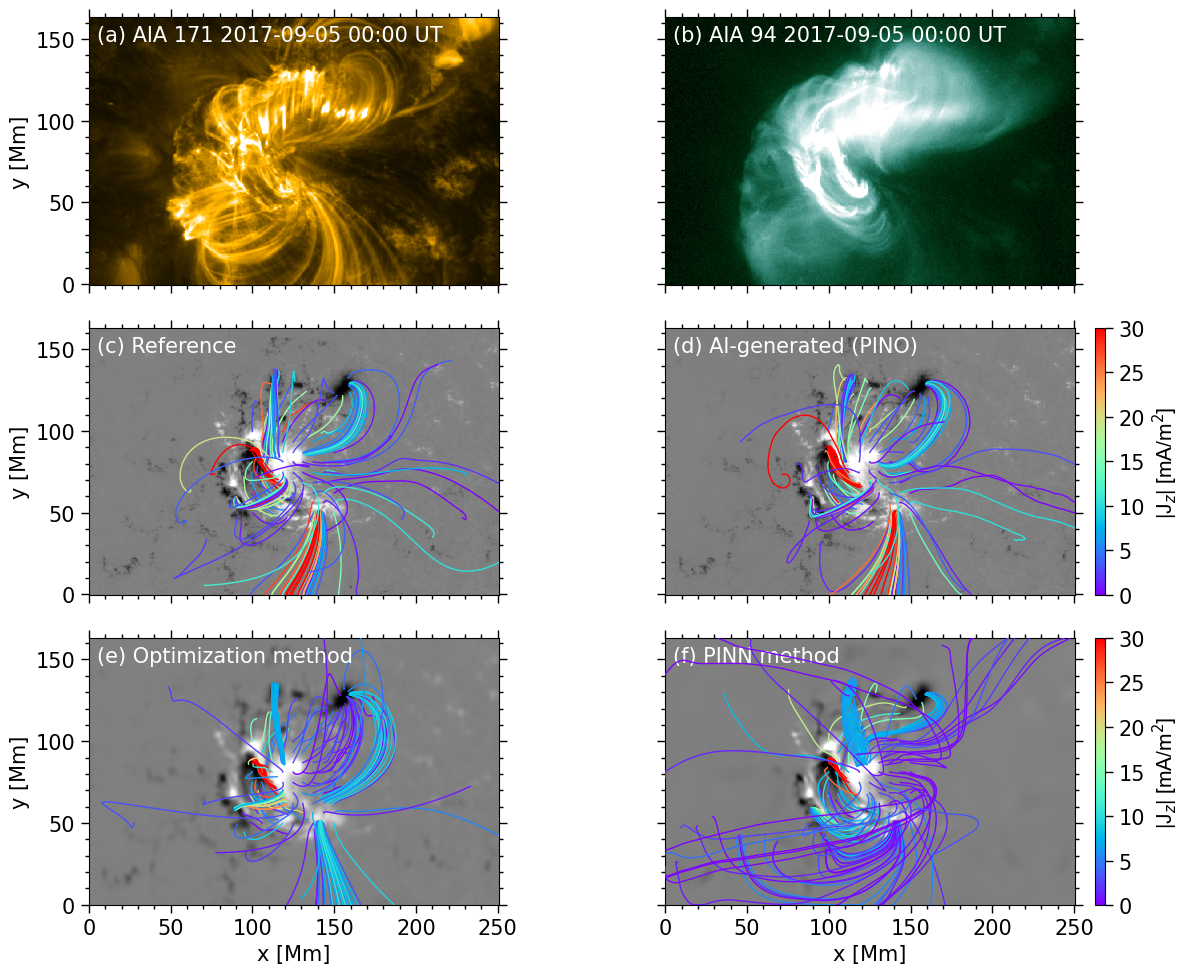

In [10]:
xypoints = [
    (100, 90, 0),
    (100, 89.5, 0),
    (100, 89, 0),
    (100, 88.5, 0),
    (100.5, 90, 0),
    (100.5, 89.5, 0),
    (100.5, 89, 0),
    (100.5, 88.5, 0),
    (99.5, 90, 0),
    (99.5, 89.5, 0),
    (99.5, 89, 0),
    (99.5, 88.5, 0),

    # (156, 130, 0),
    # (156, 129.5, 0),
    # (156, 129, 0),
    # (156, 128.5, 0),
    # (156.5, 130, 0),
    # (156.5, 129.5, 0),
    # (156.5, 129, 0),
    # (156.5, 128.5, 0),
    # # (155.5, 130, 0),
    # (155.5, 129.5, 0),
    # (155.5, 129, 0),
    # (155.5, 128.5, 0),

    (160, 130, 0),
    (160, 129.5, 0),
    (160, 129, 0),
    (160, 128.5, 0),
    (160.5, 130, 0),
    (160.5, 129.5, 0),
    (160.5, 129, 0),
    (160.5, 128.5, 0),
    # (155.5, 130, 0),
    (159.5, 129.5, 0),
    (159.5, 129, 0),
    (159.5, 128.5, 0),

    # (156, 125, 0),
    # (156, 124.5, 0),
    # (156, 124, 0),
    # (156, 123.5, 0),
    # (156.5, 125, 0),
    # (156.5, 124.5, 0),
    # (156.5, 124, 0),
    # (156.5, 123.5, 0),
    # (155.5, 125, 0),
    # (155.5, 124.5, 0),
    # (155.5, 129, 0),
    # (155.5, 123.5, 0),

    (115, 132, 0),
    (115, 131.5, 0),
    (115, 131, 0),
    (115, 130.5, 0),
    (115.5, 132, 0),
    (115.5, 131.5, 0),
    (115.5, 131, 0),
    (115.5, 130.5, 0),
    (114.5, 132, 0),
    (114.5, 131.5, 0),
    (114.5, 131, 0),
    (114.5, 130.5, 0),

    (115, 130, 0),
    (115, 129.5, 0),
    (115, 129, 0),
    (115, 128.5, 0),
    (115.5, 130, 0),
    (115.5, 129.5, 0),
    (115.5, 129, 0),
    (115.5, 128.5, 0),
    (114.5, 130, 0),
    (114.5, 129.5, 0),
    (114.5, 129, 0),
    (114.5, 128.5, 0),

    (90, 60, 0),
    (90, 59.5, 0),
    (90, 59, 0),
    (90, 58.5, 0),
    (90.5, 60, 0),
    (90.5, 59.5, 0),
    (90.5, 59, 0),
    (90.5, 58.5, 0),
    (89.5, 60, 0),
    (89.5, 59.5, 0),
    (89.5, 59, 0),
    (89.5, 58.5, 0),

    (143, 51.5, 0),
    (143, 51, 0),
    (143, 50.5, 0),
    (143, 50, 0),
    (142.5, 51.5, 0),
    (142.5, 51, 0),
    (142.5, 50.5, 0),
    (142.5, 50, 0),
    (142, 51.5, 0),
    (142, 51, 0),
    (142, 50.5, 0),
    (142, 50, 0),
    (141.5, 51.5, 0),
    (141.5, 51, 0),
    (141.5, 50.5, 0),
    (141.5, 50, 0),
    (141, 51.5, 0),
    (141, 51, 0),
    (141, 50.5, 0),
    (141, 50, 0),
    (140.5, 51.5, 0),
    (140.5, 51, 0),
    (140.5, 50.5, 0),
    (140.5, 50, 0),
    (140, 51.5, 0),
    (140, 51, 0),
    (140, 50.5, 0),
    (140, 50, 0),
    
    # (90, 68, 0),
    # (90, 67.5, 0),
    # (90, 67, 0),
    # (90, 66.5, 0),
    # (89.5, 68, 0),
    # (89.5, 67.5, 0),
    # (89.5, 67, 0),
    # (89.5, 66.5, 0),
    # (89, 68, 0),
    # (89, 67.5, 0),
    # (89, 67, 0),
    # (89, 66.5, 0),
    # (88.5, 68, 0),
    # (88.5, 67.5, 0),
    # (88.5, 67, 0),
    # (88.5, 66.5, 0),
    # (88, 68, 0),
    # (88, 67.5, 0),
    # (88, 67, 0),
    # (88, 66.5, 0),

    # (121, 79.5, 0),
    # (121, 79, 0),
    # (121, 78.5, 0),
    # (121, 78, 0),
    # (120.5, 79.5, 0),
    # (120.5, 79, 0),
    # (120.5, 78.5, 0),
    # (120.5, 78, 0),
    # (120, 79.5, 0),
    # (120, 79, 0),
    # (120, 78.5, 0),
    # (120, 78, 0),
    # (119.5, 79.5, 0),
    # (119.5, 79, 0),
    # (119.5, 78.5, 0),
    # (119.5, 78, 0),
    # (119, 79.5, 0),
    # (119, 79, 0),
    # (119, 78.5, 0),
    # (119, 78, 0),

    # (100, 100, 0),
    # (100, 99.5, 0),
    # (100, 99, 0),
    # (100, 98.5, 0),
    # (99.5, 100, 0),
    # (99.5, 99.5, 0),
    # (99.5, 99, 0),
    # (99.5, 98.5, 0),
    # (99, 100, 0),
    # (99, 99.5, 0),
    # (99, 99, 0),
    # (99, 98.5, 0),

    # (120, 126, 0),
    # (119.5, 126, 0),
    # (119, 126, 0),
    # (118.5, 126, 0),
    # (120, 125.5, 0),
    # (119.5, 125.5, 0),
    # (119, 125.5, 0),
    # (118.5, 125.5, 0),
    # (120, 125, 0),
    # (119.5, 125, 0),
    # (119, 125, 0),
    # (118.5, 125, 0),
    # (120, 124.5, 0),
    # (119.5, 124.5, 0),
    # (119, 124.5, 0),
    # (118.5, 124.5, 0),
    # (120, 124, 0),
    # (119.5, 124, 0),
    # (119, 124, 0),
    # (118.5, 124, 0),
]

xx = np.linspace(100, 150, 9)
yy = np.linspace(50, 100, 9)
xypoints_sparse = np.array([(x, y, 0) for x in xx for y in yy])

xypoints += xypoints_sparse.tolist()

draw(xypoints, filename='fl_12673.png')

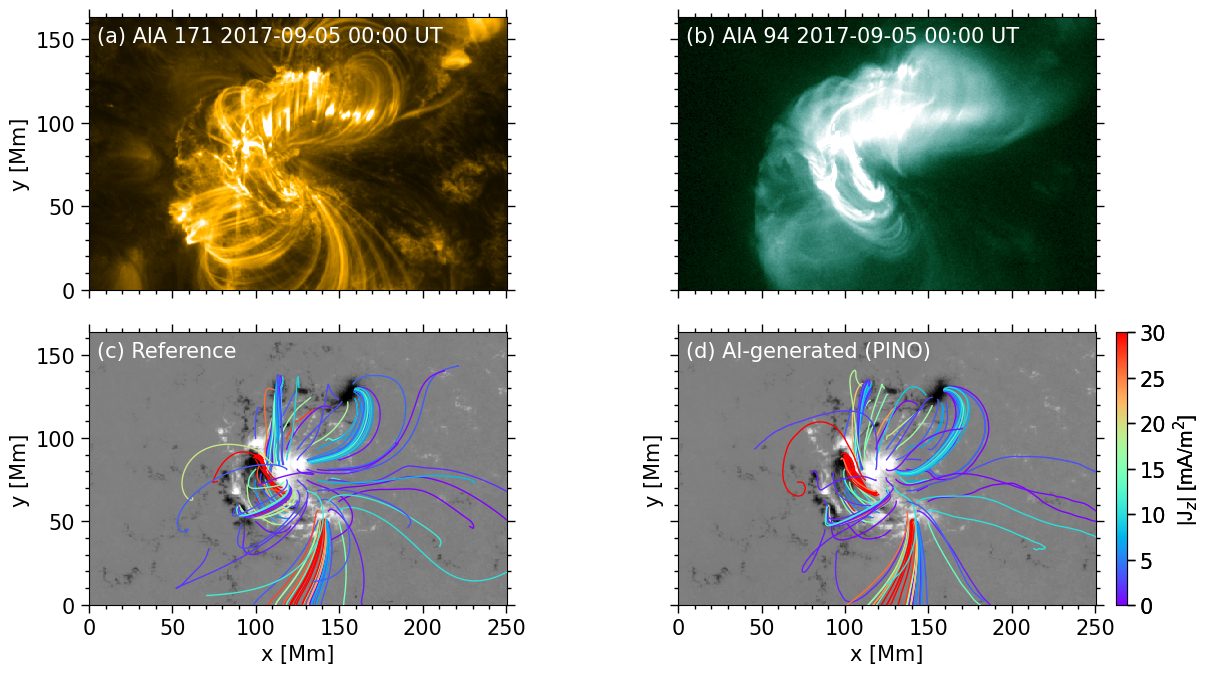

In [11]:
draw_2(xypoints, filename='fl_12673_2.png')